In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

Loading training file: training_dataset/training_benign_labeled.csv
Loading training file: training_dataset/training_brute_force_attack_labeled.csv
Loading training file: training_dataset/training_ddos_attack_labeled.csv
Loading training file: training_dataset/training_gtp_encapsulation_labeled.csv
Loading training file: training_dataset/training_gtp_malformed_labeled.csv
Loading training file: training_dataset/training_intra_upf_ddos_attack_labeled.csv
Loading training file: adversarial_dataset/adv_eps_0.90_inference_benign_labeled.csv
Loading training file: adversarial_dataset/adv_eps_0.90_inference_brute_force_attack_labeled.csv
Loading training file: adversarial_dataset/adv_eps_0.90_inference_ddos_attack_labeled.csv
Loading training file: adversarial_dataset/adv_eps_0.90_inference_gtp_encapsulation_labeled.csv
Loading training file: adversarial_dataset/adv_eps_0.90_inference_gtp_malformed_labeled.csv
Loading training file: adversarial_dataset/adv_eps_0.90_inference_intra_upf_ddos_a

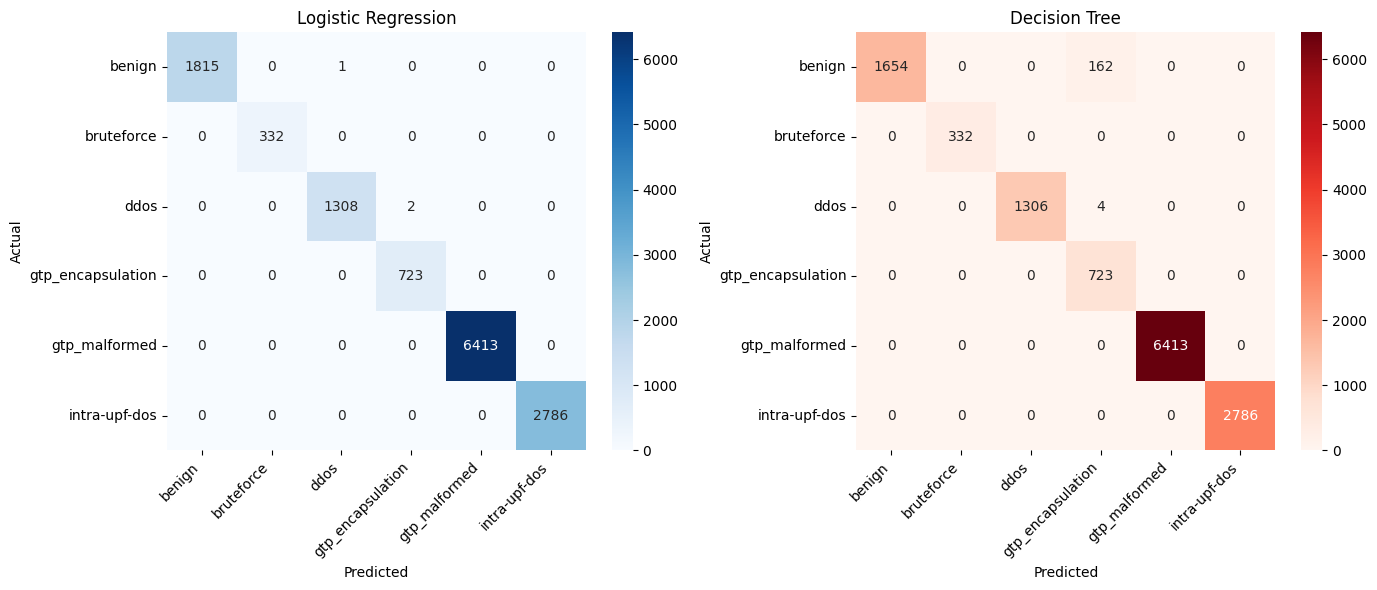

Evaluation complete.


In [76]:
# eval_adversarial_inference.py
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -----------------------------
# Config - adjust as needed
# -----------------------------
training_folder = "training_dataset"
adversarial_folder = "adversarial_dataset"
original_folder = "original_dataset"  # only to infer original file names if needed

# Epsilon to use for the ddos file specifically
eps_for_ddos = "0.1"   # will look for adv_eps_0.1_inference_ddos_attack_labeled.csv

# If no adv file found for some original, fallback to using adv_eps_0_inference_... or original inference file
fallback_eps_patterns = ["0", "0.*"]  # check adv_eps_0_first, adv_eps_0.* etc.

# -----------------------------
# Helper functions
# -----------------------------
def list_csv_files(folder):
    return sorted(f for f in os.listdir(folder) if f.endswith(".csv"))

def remove_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.95) -> pd.DataFrame:
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    if to_drop:
        print(f"Removing {len(to_drop)} highly correlated features: {to_drop}")
        return df.drop(columns=to_drop)
    return df

def preprocess_train(df: pd.DataFrame, non_feature_cols=None):
    """Preprocess training df. Returns (X_df, y_ser, X_scaled, y_encoded) and fits encoders/scalers."""
    if non_feature_cols is None:
        non_feature_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'source_file']

    feature_cols = [c for c in df.columns if c not in non_feature_cols + ['Label']]
    X = df[feature_cols].copy()
    y = df['Label'].copy().astype(str).str.strip().str.lower().replace(r'\s+', ' ', regex=True)

    # convert object cols to numeric where possible
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    # Fill numeric missing values with median
    X = X.fillna(X.median(numeric_only=True))

    # Replace infinities
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median(numeric_only=True))

    # Remove highly correlated features
    X = remove_highly_correlated_features(X, threshold=0.95)
    feature_names = list(X.columns)

    # Fit label encoder and scaler(s)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    scaler_std = StandardScaler()
    X_scaled = scaler_std.fit_transform(X)

    # Also keep minmax scaler if needed for adversarial generation pipelines
    scaler_minmax = MinMaxScaler()
    X_minmax = scaler_minmax.fit_transform(X)

    return {
        "X_df": X,
        "y": y,
        "X_scaled": X_scaled,
        "y_enc": y_enc,
        "feature_names": feature_names,
        "label_encoder": le,
        "scaler_std": scaler_std,
        "scaler_minmax": scaler_minmax
    }

def preprocess_test(df: pd.DataFrame, preprocess_info, non_feature_cols=None):
    """Preprocess test/adversarial df using training preprocess info. Returns X_df, y_ser, X_scaled, y_enc"""
    if non_feature_cols is None:
        non_feature_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'source_file']

    feature_names = preprocess_info["feature_names"]
    le = preprocess_info["label_encoder"]
    scaler_std = preprocess_info["scaler_std"]
    scaler_minmax = preprocess_info["scaler_minmax"]

    feature_cols = [c for c in df.columns if c not in non_feature_cols + ['Label']]
    X = df[feature_cols].copy()
    y = df['Label'].copy().astype(str).str.strip().str.lower().replace(r'\s+', ' ', regex=True)

    # convert object cols to numeric where possible
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    # Fill missing
    X = X.fillna(X.median(numeric_only=True))
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median(numeric_only=True))

    # Add missing features, drop extras, reorder
    missing = set(feature_names) - set(X.columns)
    extra = set(X.columns) - set(feature_names)
    if missing:
        for feat in missing:
            X[feat] = 0
    if extra:
        X = X.drop(columns=list(extra))
    X = X[feature_names]

    # Filter labels unseen in training
    valid_mask = y.isin(list(le.classes_))
    if not valid_mask.all():
        print("Warning: some test labels unseen in training will be removed:", np.unique(y[~valid_mask]))
    X = X.loc[valid_mask].copy()
    y = y.loc[valid_mask].copy()

    y_enc = le.transform(y)
    X_scaled = scaler_std.transform(X)
    X_minmax = scaler_minmax.transform(X)  # if you need minmax

    return {
        "X_df": X,
        "y": y,
        "X_scaled": X_scaled,
        "y_enc": y_enc,
        "X_minmax": X_minmax
    }

def evaluate_model(model, X, y_true_enc, le, model_name="model"):
    y_pred = model.predict(X)
    acc = accuracy_score(y_true_enc, y_pred)
    print(f"\n=== Results for {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_true_enc, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_true_enc, y_pred)
    return {"acc": acc, "y_pred": y_pred, "cm": cm}

# -----------------------------
# 1) Load all training CSVs and train preprocessing & models
# -----------------------------



train_csvs = ["training_dataset/training_benign_labeled.csv",
              "training_dataset/training_brute_force_attack_labeled.csv",
              "training_dataset/training_ddos_attack_labeled.csv",
              "training_dataset/training_gtp_encapsulation_labeled.csv",
              "training_dataset/training_gtp_malformed_labeled.csv",
              "training_dataset/training_intra_upf_ddos_attack_labeled.csv"
              ]
adv_csvs   = [os.path.join(adversarial_folder, f)
              for f in list_csv_files(adversarial_folder)
              if f.startswith(f"adv_eps_0.90")]

combined_csvs = train_csvs + adv_csvs
# print("Training CSV files:", combined_csvs)

# load and concat
train_dfs = []
for f in combined_csvs:
    print("Loading training file:", f)
    df = pd.read_csv(f)
    df = df.drop_duplicates()
    train_dfs.append(df)
train_all = pd.concat(train_dfs, ignore_index=True)
print("Combined training shape:", train_all.shape)

# Preprocess training data: fits encoders/scalers, removes correlated features
prep = preprocess_train(train_all)
feature_names = prep["feature_names"]
label_encoder = prep["label_encoder"]
scaler_std = prep["scaler_std"]
scaler_minmax = prep["scaler_minmax"]

X_train = prep["X_scaled"]
y_train = prep["y_enc"]

# Train classifiers
print("\nTraining Logistic Regression...")
clf_lr = LogisticRegression(max_iter=2000, class_weight=None, random_state=42)
clf_lr.fit(X_train, y_train)

print("Training Decision Tree...")
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

print("Training complete.\n")

# -----------------------------
# 2) Build adversarial inference set per your rule
#    - For file that is ddos_attack_labeled.csv -> adv_eps_{eps_for_ddos}_inference_ddos_attack_labeled.csv
#    - For other files -> adv_eps_0.*_inference_<origfilename> (we prefer eps=0 or 0.*)
# -----------------------------



selected_adv_paths = ['adversarial_dataset/adv_eps_0.95_inference_benign_labeled.csv',
                      'adversarial_dataset/adv_eps_0.95_inference_brute_force_attack_labeled.csv',
                      'adversarial_dataset/adv_eps_0.95_inference_ddos_attack_labeled.csv', ## using eps=0.1 here
                      'adversarial_dataset/adv_eps_0.95_inference_gtp_encapsulation_labeled.csv',
                      'adversarial_dataset/adv_eps_0.95_inference_gtp_malformed_labeled.csv',
                      'adversarial_dataset/adv_eps_0.95_inference_intra_upf_ddos_attack_labeled.csv']

# Load and concatenate selected adv files into a single test DataFrame
test_dfs = []
for p in selected_adv_paths:
    print("Loading adversarial test file:", p)
    df = pd.read_csv(p)
    test_dfs.append(df)
test_all = pd.concat(test_dfs, ignore_index=True)
print("Combined adversarial test shape:", test_all.shape)

# -----------------------------
# 3) Preprocess test set using training preprocess info
# -----------------------------
test_prep = preprocess_test(test_all, prep)
X_test = test_prep["X_scaled"]
y_test_enc = test_prep["y_enc"]
y_test_ser = test_prep["y"]

# -----------------------------
# 4) Predict and evaluate both models
# -----------------------------

res_lr = evaluate_model(clf_lr, X_test, y_test_enc, label_encoder, "Logistic Regression")
res_dt = evaluate_model(clf_dt, X_test, y_test_enc, label_encoder, "Decision Tree")


# -----------------------------
# Plot confusion matrices side by side
# -----------------------------
def plot_two_cms(cm1, cm2, labels, title1="LR", title2="DT"):
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    sns.heatmap(cm1, annot=True, fmt="d", ax=axes[0], cmap="Blues")
    axes[0].set_title(title1)
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    axes[0].set_xticklabels(labels, rotation=45, ha='right')
    axes[0].set_yticklabels(labels, rotation=0)

    sns.heatmap(cm2, annot=True, fmt="d", ax=axes[1], cmap="Reds")
    axes[1].set_title(title2)
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    axes[1].set_xticklabels(labels, rotation=45, ha='right')
    axes[1].set_yticklabels(labels, rotation=0)

    plt.tight_layout()
    plt.show()

plot_two_cms(res_lr["cm"], res_dt["cm"], labels=label_encoder.classes_, title1="Logistic Regression", title2="Decision Tree")
print("Evaluation complete.")


In [ ]:
# -----------------------------
# 1) Load all training CSVs and train preprocessing & models
# -----------------------------
results = []

for eps in np.arange(0, 1, 0.05):
    formatted_eps = f"{eps:.2f}"
    print(f"Processing for epsilon: {formatted_eps}")
    train_csvs = ["training_dataset/training_benign_labeled.csv",
                "training_dataset/training_brute_force_attack_labeled.csv",
                "training_dataset/training_ddos_attack_labeled.csv",
                "training_dataset/training_gtp_encapsulation_labeled.csv",
                "training_dataset/training_gtp_malformed_labeled.csv",
                "training_dataset/training_intra_upf_ddos_attack_labeled.csv"
                ]
    adv_csvs   = [os.path.join(adversarial_folder, f)
                for f in list_csv_files(adversarial_folder)
                if f.startswith(f"adv_eps_{formatted_eps}_inference_")]

    combined_csvs = train_csvs + adv_csvs
    # print("Training CSV files:", combined_csvs)

    # load and concat
    train_dfs = []
    for f in combined_csvs:
        # print("Loading training file:", f)
        df = pd.read_csv(f)
        df = df.drop_duplicates()
        train_dfs.append(df)
    train_all = pd.concat(train_dfs, ignore_index=True)
    print("Combined training shape:", train_all.shape)

    # Preprocess training data: fits encoders/scalers, removes correlated features
    prep = preprocess_train(train_all)
    feature_names = prep["feature_names"]
    label_encoder = prep["label_encoder"]
    scaler_std = prep["scaler_std"]
    scaler_minmax = prep["scaler_minmax"]

    X_train = prep["X_scaled"]
    y_train = prep["y_enc"]

    # Oversample after preprocessing

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Train classifiers
    print("\nTraining Logistic Regression...")
    clf_lr = LogisticRegression(max_iter=2000, class_weight=None, random_state=42)
    clf_lr.fit(X_resampled, y_resampled)

    print("Training Decision Tree...")
    clf_dt = DecisionTreeClassifier(random_state=42)
    clf_dt.fit(X_resampled, y_resampled)

    print("Training complete.\n")

    # -----------------------------
    # 2) Build adversarial inference set per your rule
    #    - For file that is ddos_attack_labeled.csv -> adv_eps_{eps_for_ddos}_inference_ddos_attack_labeled.csv
    #    - For other files -> adv_eps_0.*_inference_<origfilename> (we prefer eps=0 or 0.*)
    # -----------------------------



    selected_adv_paths = ['adversarial_dataset/adv_eps_0.95_inference_benign_labeled.csv',
                        'adversarial_dataset/adv_eps_0.95_inference_brute_force_attack_labeled.csv',
                        'adversarial_dataset/adv_eps_0.95_inference_ddos_attack_labeled.csv',
                        'adversarial_dataset/adv_eps_0.95_inference_gtp_encapsulation_labeled.csv',
                        'adversarial_dataset/adv_eps_0.95_inference_gtp_malformed_labeled.csv',
                        'adversarial_dataset/adv_eps_0.95_inference_intra_upf_ddos_attack_labeled.csv']

    # Load and concatenate selected adv files into a single test DataFrame
    test_dfs = []
    for p in selected_adv_paths:
        # print("Loading adversarial test file:", p)
        df = pd.read_csv(p)
        test_dfs.append(df)
    test_all = pd.concat(test_dfs, ignore_index=True)
    print("Adversarial test shape:", test_all.shape)

    # -----------------------------
    # 3) Preprocess test set using training preprocess info
    # -----------------------------
    test_prep = preprocess_test(test_all, prep)
    X_test = test_prep["X_scaled"]
    y_test_enc = test_prep["y_enc"]
    y_test_ser = test_prep["y"]

    # -----------------------------
    # 4) Predict and evaluate both models
    # -----------------------------

    res_lr = evaluate_model(clf_lr, X_test, y_test_enc, label_encoder, "Logistic Regression")
    res_dt = evaluate_model(clf_dt, X_test, y_test_enc, label_encoder, "Decision Tree")

        # Store results
    results.append({
        "epsilon": eps,
        "LR_acc": res_lr["acc"],
        "DT_acc": res_dt["acc"]
    })

Processing for epsilon: 0.00
Combined training shape: (66886, 84)
Removing 17 highly correlated features: ['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Length', 'Fwd Packets/s', 'Packet Length Variance', 'PSH Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']

Training Logistic Regression...
Training Decision Tree...
Training complete.

Adversarial test shape: (13380, 84)

=== Results for Logistic Regression ===
Accuracy: 0.1361
Classification report:
                   precision    recall  f1-score   support

           benign       0.32      1.00      0.48      1816
       bruteforce       1.00      0.02      0.03       332
             ddos       0.00      0.00      0.00      1310
gtp_encapsulation       0.00      0.00      0.00       723
    gtp_malformed       0.00      0.00      0.00      6413
    intra-upf-dos       0.00      0.00      0.

/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

Combined training shape: (66886, 84)
Removing 11 highly correlated features: ['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Idle Mean', 'Idle Max', 'Idle Min']

Training Logistic Regression...
Training Decision Tree...
Training complete.

Adversarial test shape: (13380, 84)

=== Results for Logistic Regression ===
Accuracy: 0.9783
Classification report:
                   precision    recall  f1-score   support

           benign       0.98      0.92      0.95      1816
       bruteforce       0.80      1.00      0.89       332
             ddos       0.88      0.98      0.92      1310
gtp_encapsulation       1.00      0.98      0.99       723
    gtp_malformed       1.00      1.00      1.00      6413
    intra-upf-dos       1.00      0.96      0.98      2786

         accuracy                           0.98     13380
        macro avg       0.94      0.97      0.96     13380
     we

/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

Combined training shape: (66886, 84)
Removing 10 highly correlated features: ['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Fwd Segment Size Avg', 'Idle Mean', 'Idle Max', 'Idle Min']

Training Logistic Regression...
Training Decision Tree...
Training complete.

Adversarial test shape: (13380, 84)

=== Results for Logistic Regression ===
Accuracy: 1.0000
Classification report:
                   precision    recall  f1-score   support

           benign       1.00      1.00      1.00      1816
       bruteforce       1.00      1.00      1.00       332
             ddos       1.00      1.00      1.00      1310
gtp_encapsulation       1.00      1.00      1.00       723
    gtp_malformed       1.00      1.00      1.00      6413
    intra-upf-dos       1.00      1.00      1.00      2786

         accuracy                           1.00     13380
        macro avg       1.00      1.00      1.00     13380
     weighted avg       1.00      1.00

/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

Combined training shape: (66886, 84)
Removing 20 highly correlated features: ['Bwd Packet Length Max', 'Flow Bytes/s', 'Flow IAT Min', 'Bwd IAT Mean', 'Bwd IAT Max', 'Fwd PSH Flags', 'Fwd URG Flags', 'Bwd Header Length', 'Packet Length Max', 'Packet Length Std', 'ACK Flag Count', 'Bwd Bytes/Bulk Avg', 'Subflow Bwd Packets', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Idle Mean', 'Idle Max', 'Idle Min']

Training Logistic Regression...
Training Decision Tree...
Training complete.

Adversarial test shape: (13380, 84)

=== Results for Logistic Regression ===
Accuracy: 0.9786
Classification report:
                   precision    recall  f1-score   support

           benign       1.00      1.00      1.00      1816
       bruteforce       1.00      1.00      1.00       332
             ddos       0.82      1.00      0.90      1310
gtp_encapsulation       1.00      1.00      1.00       723
    gtp_malformed       1.00      0.96      0.98      6413
    intra-upf-

/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/swengapp23/5g-attack-with-fgsm/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

                   precision    recall  f1-score   support

           benign       1.00      1.00      1.00      1816
       bruteforce       1.00      1.00      1.00       332
             ddos       0.17      1.00      0.29      1310
gtp_encapsulation       1.00      1.00      1.00       723
    gtp_malformed       0.00      0.00      0.00      6413
    intra-upf-dos       1.00      1.00      1.00      2786

         accuracy                           0.52     13380
        macro avg       0.69      0.83      0.71     13380
     weighted avg       0.44      0.52      0.45     13380


=== Results for Decision Tree ===
Accuracy: 0.9996
Classification report:
                   precision    recall  f1-score   support

           benign       1.00      1.00      1.00      1816
       bruteforce       1.00      1.00      1.00       332
             ddos       1.00      1.00      1.00      1310
gtp_encapsulation       1.00      1.00      1.00       723
    gtp_malformed       1.00      1.

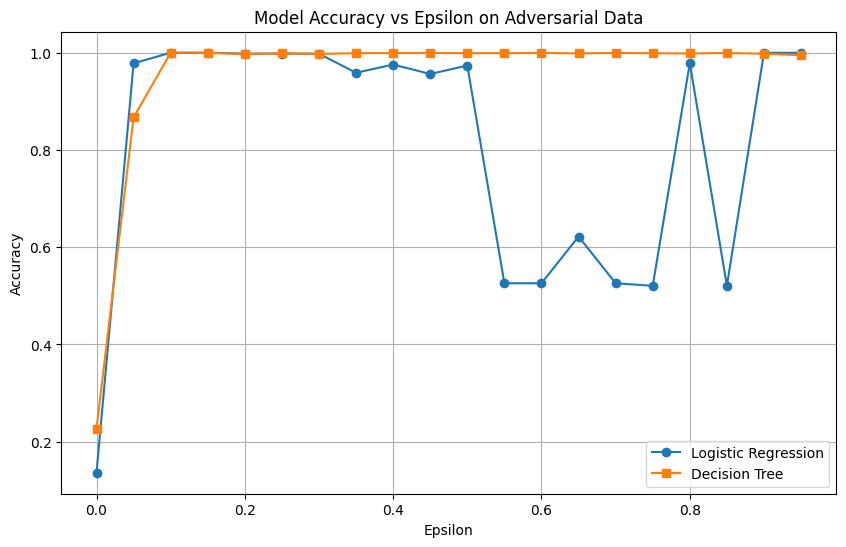

In [67]:
# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

plt.figure(figsize=(10,6))
plt.plot(results_df["epsilon"], results_df["LR_acc"], marker="o", label="Logistic Regression")
plt.plot(results_df["epsilon"], results_df["DT_acc"], marker="s", label="Decision Tree")

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs Epsilon on Adversarial Data")
plt.legend()
plt.grid(True)
plt.show()
